# Image Editing with InstructPix2Pix and OpenVINO

The InstructPix2Pix is a conditional diffusion model that edits images based on written instructions provided by the user.
Generative image editing models traditionally target a single editing task like style transfer or translation between image domains. Text guidance gives us an opportunity to solve multiple tasks with a single model.
The InstructPix2Pix method works different than existing text-based image editing in that it enables editing from instructions that tell the model what action to perform instead of using text labels, captions or descriptions of input/output images. A key benefit of following editing instructions is that the user can just tell the model exactly what to do in natural written text. There is no need for the user to provide extra information, such as example images or descriptions of visual content that remain constant between the input and output images. More details about this approach can be found in this [paper](https://arxiv.org/pdf/2211.09800.pdf) and [repository](https://github.com/timothybrooks/instruct-pix2pix).

This notebook demonstrates how to convert and run the InstructPix2Pix model using OpenVINO.

Notebook contains the following steps:

1. Convert PyTorch models to OpenVINO IR format, using Model Conversion API.
3. Run InstructPix2Pix pipeline with OpenVINO.


### Table of content:
- [Prerequisites](#Prerequisites-Uparrow)
- [Create Pytorch Models pipeline](#Create-Pytorch-Models-pipeline-Uparrow)
- [Convert Models to OpenVINO IR](#Convert-Models-to-OpenVINO-IR-Uparrow)
    - [Text Encoder](#Text-Encoder-Uparrow)
    - [VAE](#VAE-Uparrow)
    - [Unet](#Unet-Uparrow)
- [Prepare Inference Pipeline](#Prepare-Inference-Pipeline-Uparrow)
- [Quantization](#Quantization-Uparrow)
    - [Prepare calibration dataset](#Prepare-calibration-dataset-Uparrow)
    - [Run quantization](#Run-quantization-Uparrow)
    - [Compare inference time of the converted IR and quantized models](#Compare-inference-time-of-the-converted-IR-and-quantized-models-Uparrow)
- [Interactive demo with Gradio](#Interactive-demo-with-Gradio-Uparrow)

## Prerequisites [$\Uparrow$](#Table-of-content:)

Install necessary packages

In [ ]:
%pip install -q "transformers>=4.25.1" accelerate gradio
%pip install -q "git+https://github.com/huggingface/diffusers.git"
%pip install -q "openvino>=2023.1.0"

## Create Pytorch Models pipeline [$\Uparrow$](#Table-of-content:)

`StableDiffusionInstructPix2PixPipeline` is an end-to-end inference pipeline that you can use to edit images from text instructions with just a few lines of code provided as part 🤗🧨[diffusers](https://huggingface.co/docs/diffusers/index) library.

First, we load the pre-trained weights of all components of the model.

> **NOTE**: Initially, model loading can take some time due to downloading the weights. Also, the download speed depends on your internet connection.

In [ ]:
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float32, safety_checker=None)
scheduler_config = pipe.scheduler.config
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()

del pipe

## Convert Models to OpenVINO IR [$\Uparrow$](#Table-of-content:)

OpenVINO supports PyTorch models using [Model Conversion API](https://docs.openvino.ai/2023.1/openvino_docs_model_processing_introduction.html) to convert the model to IR format. `ov.convert_model` function accepts PyTorch model object and example input and then converts it to `ov.Model` class instance that ready to use for loading on device or can be saved on disk using `ov.save_model`.

The InstructPix2Pix model is based on Stable Diffusion, a large-scale text-to-image latent diffusion model. You can find more details about how to run Stable Diffusion for text-to-image generation with OpenVINO in a separate [tutorial](../225-stable-diffusion-text-to-image/225-stable-diffusion-text-to-image.ipynb).


The model consists of three important parts:

* Text Encoder - to create conditions from a text prompt.
* Unet - for step-by-step denoising latent image representation.
* Autoencoder (VAE) - to encode the initial image to latent space for starting the denoising process and decoding latent space to image, when denoising is complete.

Let us convert each part.

### Text Encoder [$\Uparrow$](#Table-of-content:)

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the UNet. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

Input of the text encoder is tensor `input_ids`, which contains indexes of tokens from text processed by tokenizer and padded to maximum length accepted by the model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - pooled output for whole model hidden states.

In [3]:
from pathlib import Path
import openvino as ov
import gc

core = ov.Core()

TEXT_ENCODER_OV_PATH = Path("text_encoder.xml")

def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


def convert_encoder(text_encoder: torch.nn.Module, ir_path:Path):
    """
    Convert Text Encoder mode. 
    Function accepts text encoder model, and prepares example inputs for conversion, 
    Parameters: 
        text_encoder (torch.nn.Module): text_encoder model from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    input_ids = torch.ones((1, 77), dtype=torch.long)
    # switch model to inference mode
    text_encoder.eval()

    # disable gradients calculation for reducing memory consumption
    with torch.no_grad():
        # Export model to IR format
        ov_model = ov.convert_model(text_encoder, example_input=input_ids, input=[(1,77),])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'Text Encoder successfully converted to IR and saved to {ir_path}')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder(text_encoder, TEXT_ENCODER_OV_PATH)
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")

del text_encoder
gc.collect()

Text encoder will be loaded from text_encoder.xml


32

### VAE [$\Uparrow$](#Table-of-content:)

The VAE model consists of two parts: an encoder and a decoder.

* The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the UNet model.
* The decoder, conversely, transforms the latent representation back into an image.

In comparison with a text-to-image inference pipeline, where VAE is used only for decoding, the pipeline also involves the original image encoding. As the two parts are used separately in the pipeline on different steps, and do not depend on each other, we should convert them into two independent models.

In [4]:
VAE_ENCODER_OV_PATH = Path("vae_encoder.xml")

def convert_vae_encoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for encoding to IR format. 
    Function accepts vae model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model from StableDiffusio pipeline 
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            return self.vae.encode(x=image)["latent_dist"].sample()
    vae_encoder = VAEEncoderWrapper(vae)
    vae_encoder.eval()
    image = torch.zeros((1, 3, 512, 512))
    with torch.no_grad():
        ov_model = ov.convert_model(vae_encoder, example_input=image, input=[((1,3,512,512),)])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'VAE encoder successfully converted to IR and saved to {ir_path}')


if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder(vae, VAE_ENCODER_OV_PATH)
else:
    print(f"VAE encoder will be loaded from {VAE_ENCODER_OV_PATH}")

VAE_DECODER_OV_PATH = Path('vae_decoder.xml')

def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for decoding to IR format. 
    Function accepts vae model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model frm StableDiffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)
    
    vae_decoder = VAEDecoderWrapper(vae)
    latents = torch.zeros((1, 4, 64, 64))

    vae_decoder.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(vae_decoder, example_input=latents, input=[((1,4,64,64),)])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'VAE decoder successfully converted to IR and saved to {ir_path}')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder(vae, VAE_DECODER_OV_PATH)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae
gc.collect()

VAE encoder will be loaded from vae_encoder.xml
VAE decoder will be loaded from vae_decoder.xml


0

### Unet [$\Uparrow$](#Table-of-content:)

The Unet model has three inputs:

* `scaled_latent_model_input` - the latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
* `timestep` - a current scheduler step.
* `text_embeddings` - a hidden state of the text encoder.

Model predicts the `sample` state for the next step.

In [5]:
import numpy as np

UNET_OV_PATH = Path('unet.xml')

dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64
}


def convert_unet(unet:torch.nn.Module, ir_path:Path):
    """
    Convert U-net model to IR format. 
    Function accepts unet model, prepares example inputs for conversion, 
    Parameters: 
        unet (StableDiffusionPipeline): unet from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    # prepare inputs
    encoder_hidden_state = torch.ones((3, 77, 768))
    latents_shape = (3, 8, 512 // 8, 512 // 8)
    latents = torch.randn(latents_shape)
    t = torch.from_numpy(np.array(1, dtype=float))
    dummy_inputs = (latents, t, encoder_hidden_state)
    input_info = []
    for input_tensor in dummy_inputs:
        shape = ov.PartialShape(tuple(input_tensor.shape))
        element_type = dtype_mapping[input_tensor.dtype]
        input_info.append((shape, element_type))

    unet.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(unet, example_input=dummy_inputs, input=input_info)
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'Unet successfully converted to IR and saved to {ir_path}')


if not UNET_OV_PATH.exists():
    convert_unet(unet, UNET_OV_PATH)
    gc.collect()
else:
    print(f"Unet will be loaded from {UNET_OV_PATH}")
del unet
gc.collect()

Unet will be loaded from unet.xml


0

## Prepare Inference Pipeline [$\Uparrow$](#Table-of-content:)

Putting it all together, let us now take a closer look at how the model inference works by illustrating the logical flow.

![diagram](https://user-images.githubusercontent.com/29454499/214895365-3063ac11-0486-4d9b-9e25-8f469aba5e5d.png)

The InstructPix2Pix model takes both an image and a text prompt as an input. The image is transformed to latent image representations of size $64 \times 64$, using the encoder part of variational autoencoder, whereas the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next, the UNet model iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the UNet, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm.

The *denoising* process is repeated a given number of times (by default 100) to retrieve step-by-step better latent image representations.
Once it has been completed, the latent image representation is decoded by the decoder part of the variational auto encoder.


In [6]:
from diffusers..pipelines.pipeline_utils import DiffusionPipeline
from transformers import CLIPTokenizer
from typing import Union, List, Optional, Tuple
import PIL
import cv2


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: PIL.Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       pad (Tuple[int]): pading size for each dimension for restoring image size in postprocessing
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(
        512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, pad


def randn_tensor(
    shape: Union[Tuple, List],
    dtype: Optional[np.dtype] = np.float32,
):
    """
    Helper function for generation random values tensor with given shape and data type
    
    Parameters:
      shape (Union[Tuple, List]): shape for filling random values
      dtype (np.dtype, *optiona*, np.float32): data type for result
    Returns:
      latents (np.ndarray): tensor with random values with given data type and shape (usually represents noise in latent space)
    """
    latents = np.random.randn(*shape).astype(dtype)

    return latents


class OVInstructPix2PixPipeline(DiffusionPipeline):
    """
    OpenVINO inference pipeline for InstructPix2Pix
    """
    def __init__(
        self,
        tokenizer: CLIPTokenizer,
        scheduler: EulerAncestralDiscreteScheduler,
        core: ov.Core,
        text_encoder: ov.Model,
        vae_encoder: ov.Model,
        unet: ov.Model,
        vae_decoder: ov.Model,
        device: str = "AUTO"
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vae_scale_factor = 8
        self.scheduler = scheduler
        self.load_models(core, device, text_encoder,
                         vae_encoder, unet, vae_decoder)

    def load_models(self, core: ov.Core, device: str, text_encoder: ov.Model, vae_encoder: ov.Model, unet: ov.Model, vae_decoder: ov.Model):
        """
        Function for loading models on device using OpenVINO
        
        Parameters:
          core (Core): OpenVINO runtime Core class instance
          device (str): inference device
          text_encoder (Model): OpenVINO Model object represents text encoder
          vae_encoder (Model): OpenVINO Model object represents vae encoder
          unet (Model): OpenVINO Model object represents unet
          vae_decoder (Model): OpenVINO Model object represents vae decoder
        Returns
          None
        """
        self.text_encoder = core.compile_model(text_encoder, device)
        self.text_encoder_out = self.text_encoder.output(0)
        self.vae_encoder = core.compile_model(vae_encoder, device)
        self.vae_encoder_out = self.vae_encoder.output(0)
        # We have to register UNet in config to be able to change it externally to collect calibration data
        self.register_to_config(unet=core.compile_model(unet, device))
        self.unet_out = self.unet.output(0)
        self.vae_decoder = core.compile_model(vae_decoder)
        self.vae_decoder_out = self.vae_decoder.output(0)

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: PIL.Image.Image,
        num_inference_steps: int = 10,
        guidance_scale: float = 7.5,
        image_guidance_scale: float = 1.5,
        eta: float = 0.0,
        latents: Optional[np.array] = None,
        output_type: Optional[str] = "pil",
    ):
        """
        Function invoked when calling the pipeline for generation.

        Parameters:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            image (`PIL.Image.Image`):
                `Image`, or tensor representing an image batch which will be repainted according to `prompt`.
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality. This pipeline requires a value of at least `1`.
            image_guidance_scale (`float`, *optional*, defaults to 1.5):
                Image guidance scale is to push the generated image towards the inital image `image`. Image guidance
                scale is enabled by setting `image_guidance_scale > 1`. Higher image guidance scale encourages to
                generate images that are closely linked to the source image `image`, usually at the expense of lower
                image quality. This pipeline requires a value of at least `1`.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
        Returns:
            image ([List[Union[np.ndarray, PIL.Image.Image]]): generaited images
            
        """

        # 1. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0 and image_guidance_scale >= 1.0
        # check if scheduler is in sigmas space
        scheduler_is_in_sigma_space = hasattr(self.scheduler, "sigmas")

        # 2. Encode input prompt
        text_embeddings = self._encode_prompt(prompt)

        # 3. Preprocess image
        orig_width, orig_height = image.size
        image, pad = preprocess(image)
        height, width = image.shape[-2:]

        # 4. set timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        # 5. Prepare Image latents
        image_latents = self.prepare_image_latents(
            image,
            do_classifier_free_guidance=do_classifier_free_guidance,
        )

        # 6. Prepare latent variables
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size,
            num_channels_latents,
            height,
            width,
            text_embeddings.dtype,
            latents,
        )

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Expand the latents if we are doing classifier free guidance.
                # The latents are expanded 3 times because for pix2pix the guidance\
                # is applied for both the text and the input image.
                latent_model_input = np.concatenate(
                    [latents] * 3) if do_classifier_free_guidance else latents

                # concat latents, image_latents in the channel dimension
                scaled_latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t)
                scaled_latent_model_input = np.concatenate(
                    [scaled_latent_model_input, image_latents], axis=1)

                # predict the noise residual
                noise_pred = self.unet([scaled_latent_model_input, t, text_embeddings])[
                    self.unet_out]

                # Hack:
                # For karras style schedulers the model does classifier free guidance using the
                # predicted_original_sample instead of the noise_pred. So we need to compute the
                # predicted_original_sample here if we are using a karras style scheduler.
                if scheduler_is_in_sigma_space:
                    step_index = (self.scheduler.timesteps == t).nonzero().item()
                    sigma = self.scheduler.sigmas[step_index].numpy()
                    noise_pred = latent_model_input - sigma * noise_pred

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_text, noise_pred_image, noise_pred_uncond = noise_pred[
                        0], noise_pred[1], noise_pred[2]
                    noise_pred = (
                        noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_image) + image_guidance_scale * (noise_pred_image - noise_pred_uncond)
                    )

                # For karras style schedulers the model does classifier free guidance using the
                # predicted_original_sample instead of the noise_pred. But the scheduler.step function
                # expects the noise_pred and computes the predicted_original_sample internally. So we
                # need to overwrite the noise_pred here such that the value of the computed
                # predicted_original_sample is correct.
                if scheduler_is_in_sigma_space:
                    noise_pred = (noise_pred - latents) / (-sigma)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents)).prev_sample.numpy()

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

        # 8. Post-processing
        image = self.decode_latents(latents, pad)

        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            image = [img.resize((orig_width, orig_height),
                                PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            image = [cv2.resize(img, (orig_width, orig_width))
                     for img in image]

        return image

    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[self.text_encoder_out]

        # duplicate text embeddings for each generation per prompt, using mps friendly method
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            uncond_tokens = [""] * batch_size
            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[
                self.text_encoder_out]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(
                uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(
                uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, you need to do two forward passes.
            # Here, you concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate(
                [text_embeddings, uncond_embeddings, uncond_embeddings])

        return text_embeddings

    def prepare_image_latents(
        self, image, batch_size=1, num_images_per_prompt=1, do_classifier_free_guidance=True
    ):
        """
        Encodes input image to latent space using VAE Encoder
        
        Parameters:
           image (np.ndarray): input image tensor
           num_image_per_prompt (int, *optional*, 1): number of image generated for promt
           do_classifier_free_guidance (bool): whether to use classifier free guidance or not
        Returns:
           image_latents: image encoded to latent space
        """

        image = image.astype(np.float32)

        batch_size = batch_size * num_images_per_prompt
        image_latents = self.vae_encoder(image)[self.vae_encoder_out]

        if batch_size > image_latents.shape[0] and batch_size % image_latents.shape[0] == 0:
            # expand image_latents for batch_size
            additional_image_per_prompt = batch_size // image_latents.shape[0]
            image_latents = np.concatenate(
                [image_latents] * additional_image_per_prompt, axis=0)
        elif batch_size > image_latents.shape[0] and batch_size % image_latents.shape[0] != 0:
            raise ValueError(
                f"Cannot duplicate `image` of batch size {image_latents.shape[0]} to {batch_size} text prompts."
            )
        else:
            image_latents = np.concatenate([image_latents], axis=0)

        if do_classifier_free_guidance:
            uncond_image_latents = np.zeros_like(image_latents)
            image_latents = np.concatenate([image_latents, image_latents, uncond_image_latents], axis=0)

        return image_latents

    def prepare_latents(self, batch_size:int, num_channels_latents:int, height:int, width:int, dtype:np.dtype = np.float32, latents:np.ndarray = None):
        """
        Preparing noise to image generation. If initial latents are not provided, they will be generated randomly, 
        then prepared latents scaled by the standard deviation required by the scheduler
        
        Parameters:
           batch_size (int): input batch size
           num_channels_latents (int): number of channels for noise generation
           height (int): image height
           width (int): image width
           dtype (np.dtype, *optional*, np.float32): dtype for latents generation
           latents (np.ndarray, *optional*, None): initial latent noise tensor, if not provided will be generated
        Returns:
           latents (np.ndarray): scaled initial noise for diffusion
        """
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if latents is None:
            latents = randn_tensor(shape, dtype=dtype)
        else:
            latents = latents

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma.numpy()
        return latents

    def decode_latents(self, latents:np.array, pad:Tuple[int]):
        """
        Decode predicted image from latent space using VAE Decoder and unpad image result
        
        Parameters:
           latents (np.ndarray): image encoded in diffusion latent space
           pad (Tuple[int]): each side padding sizes obtained on preprocessing step
        Returns:
           image: decoded by VAE decoder image
        """
        latents = 1 / 0.18215 * latents
        image = self.vae_decoder(latents)[self.vae_decoder_out]
        (_, end_h), (_, end_w) = pad[1:3]
        h, w = image.shape[2:]
        unpad_h = h - end_h
        unpad_w = w - end_w
        image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        return image

In [7]:
import matplotlib.pyplot as plt


def visualize_results(orig_img:PIL.Image.Image, processed_img:PIL.Image.Image, prompt:str):
    """
    Helper function for results visualization
    
    Parameters:
       orig_img (PIL.Image.Image): original image
       processed_img (PIL.Image.Image): processed image after editing
       prompt (str): text instruction used for editing
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "Original image"
    im_w, im_h = orig_img.size
    is_horizontal = im_h <= im_w
    figsize = (20, 30) if is_horizontal else (30, 20)
    fig, axs = plt.subplots(1 if is_horizontal else 2, 2 if is_horizontal else 1, figsize=figsize, sharex='all', sharey='all')
    fig.patch.set_facecolor('white')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(processed_img))
    list_axes[0].set_title(orig_title, fontsize=20) 
    list_axes[1].set_title(f"Prompt: {prompt}", fontsize=20)
    fig.subplots_adjust(wspace=0.0 if is_horizontal else 0.01 , hspace=0.01 if is_horizontal else 0.0)
    fig.tight_layout()
    fig.savefig("result.png", bbox_inches='tight')
    return fig

Model tokenizer and scheduler are also important parts of the pipeline. Let us define them and put all components together.
Additionally, you can provide device selecting one from available in dropdown list.

In [8]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [9]:
from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
scheduler = EulerAncestralDiscreteScheduler.from_config(scheduler_config)

ov_pipe = OVInstructPix2PixPipeline(tokenizer, scheduler, core, TEXT_ENCODER_OV_PATH, VAE_ENCODER_OV_PATH, UNET_OV_PATH, VAE_DECODER_OV_PATH, device=device.value)

/home/ltalamanova/env_ci/lib/python3.8/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `unet` directly via 'OVInstructPix2PixPipeline' object attribute is deprecated. Please access 'unet' over 'OVInstructPix2PixPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Now, you are ready to define editing instructions and an image for running the inference pipeline. You can find example results generated by the model on this [page](https://www.timothybrooks.com/instruct-pix2pix/), in case you need inspiration.
Optionally, you can also change the random generator seed for latent state initialization and number of steps.

> **Note**: Consider increasing `steps` to get more precise results. A suggested value is `100`, but it will take more time to process.

In [10]:
style = {'description_width': 'initial'}
text_prompt = widgets.Text(value=" Make it in galaxy", description='your text')
num_steps = widgets.IntSlider(min=1, max=100, value=10, description='steps:')
seed = widgets.IntSlider(min=0, max=1024, description='seed: ', value=42)
image_widget = widgets.FileUpload(
    accept='',
    multiple=False,
    description='Upload image',
    style=style
)
widgets.VBox([text_prompt, seed, num_steps, image_widget])

> **Note**: Diffusion process can take some time, depending on what hardware you select.

In [11]:
import io
import requests

default_url = "https://user-images.githubusercontent.com/29454499/223343459-4ac944f0-502e-4acf-9813-8e9f0abc8a16.jpg"
# read uploaded image
image = PIL.Image.open(io.BytesIO(image_widget.value[-1]['content']) if image_widget.value else requests.get(default_url, stream=True).raw)
image = image.convert("RGB")
print('Pipeline settings')
print(f'Input text: {text_prompt.value}')
print(f'Seed: {seed.value}')
print(f'Number of steps: {num_steps.value}')
np.random.seed(seed.value)
processed_image = ov_pipe(text_prompt.value, image, num_steps.value)

Pipeline settings
Input text:  Make it in galaxy
Seed: 42
Number of steps: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Now, let us look at the results. The top image represents the original before editing. The bottom image is the result of the editing process. The title between them contains the text instructions used for generation.

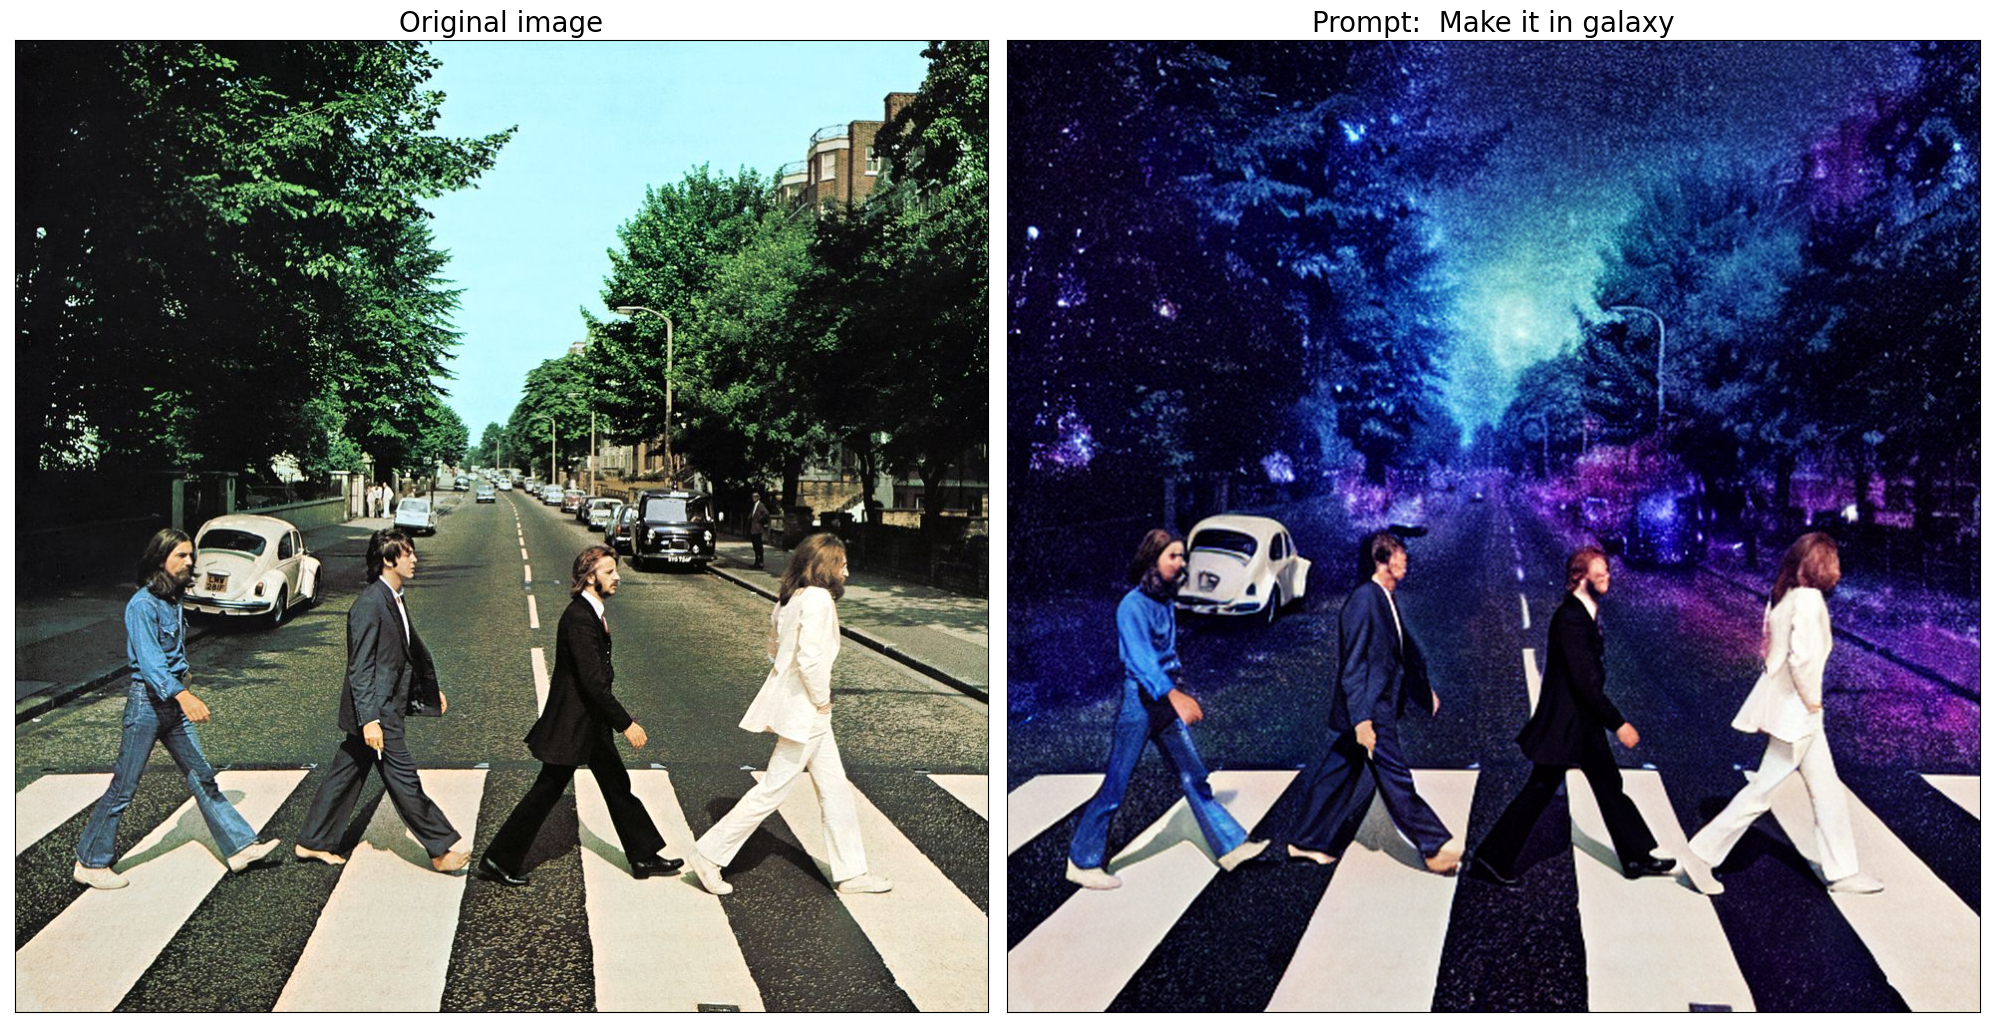

In [12]:
fig = visualize_results(image, processed_image[0], text_prompt.value)

Nice. As you can see, the picture has quite a high definition 🔥.

## Quantization [$\Uparrow$](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

The inference of UNet comprises the majority of computations in the 'InstructPix2Pix' pipeline. Thus, optimizing just one model brings substantial benefits in terms of inference speed.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized models.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [13]:
to_quantize = widgets.Checkbox(
    value=True,
    description='Quantization',
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

Let's create `skip magic` extension to skip quantization if `to_quantize` is not selected

In [14]:
def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']

load_ipython_extension(get_ipython())

### Prepare calibration dataset [$\Uparrow$](#Table-of-contents:)

We use a portion of [`fusing/instructpix2pix-1000-samples`](https://huggingface.co/datasets/fusing/instructpix2pix-1000-samples) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [15]:
%%skip not $to_quantize.value

import datasets
from transformers import Pipeline
from typing import Any, Dict, List

class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model, prob: float, data_cache: List[Any] = None):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache else []
        self.prob = np.clip(prob, 0, 1)

    def __call__(self, *args, **kwargs):
        if np.random.rand() >= self.prob:
            self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

def collect_calibration_data(pix2pix_pipeline: Pipeline, subset_size: int) -> List[Dict]:
    pix2pix_pipeline.unet = CompiledModelDecorator(pix2pix_pipeline.unet, prob=0.5)
    calibration_dataset = datasets.load_dataset("fusing/instructpix2pix-1000-samples", split="train", streaming=True).shuffle(seed=42)
    pix2pix_pipeline.set_progress_bar_config(disable=True)

    # Run inference for data collection
    for batch in calibration_dataset:
        if len(pix2pix_pipeline.unet.data_cache) >= subset_size:
            break
        prompt = batch["edit_prompt"]
        image = batch["input_image"].convert("RGB")
        _ = pix2pix_pipeline(prompt, image)

    pix2pix_pipeline.set_progress_bar_config(disable=False)
    return pix2pix_pipeline.unet.data_cache

### Run quantization [$\Uparrow$](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [ ]:
%%skip not $to_quantize.value

import nncf

if UNET_INT8_OV_PATH.exists():
    print("Loading quantized model.")
    quantized_unet = core.read_model(UNET_INT8_OV_PATH)
else:
    subset_size = 300
    unet = core.read_model(UNET_OV_PATH)
    UNET_INT8_OV_PATH = Path("unet_int8.xml")
    print("Collecting calibration data.")
    unet_calibration_data = collect_calibration_data(ov_pipe, subset_size=subset_size)
    print("Quantizing UNet.")
    quantized_unet = nncf.quantize(
        model=unet,
        subset_size=subset_size,
        calibration_dataset=nncf.Dataset(unet_calibration_data, lambda x: x),
        model_type=nncf.ModelType.TRANSFORMER
    )
    ov.save_model(quantized_unet, UNET_INT8_OV_PATH)

Let us check predictions with the quantized UNet using the same input data.

Pipeline settings
Input text:  Make it in galaxy
Seed: 42
Number of steps: 10


/home/ltalamanova/env_ci/lib/python3.8/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `unet` directly via 'OVInstructPix2PixPipeline' object attribute is deprecated. Please access 'unet' over 'OVInstructPix2PixPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/10 [00:00<?, ?it/s]

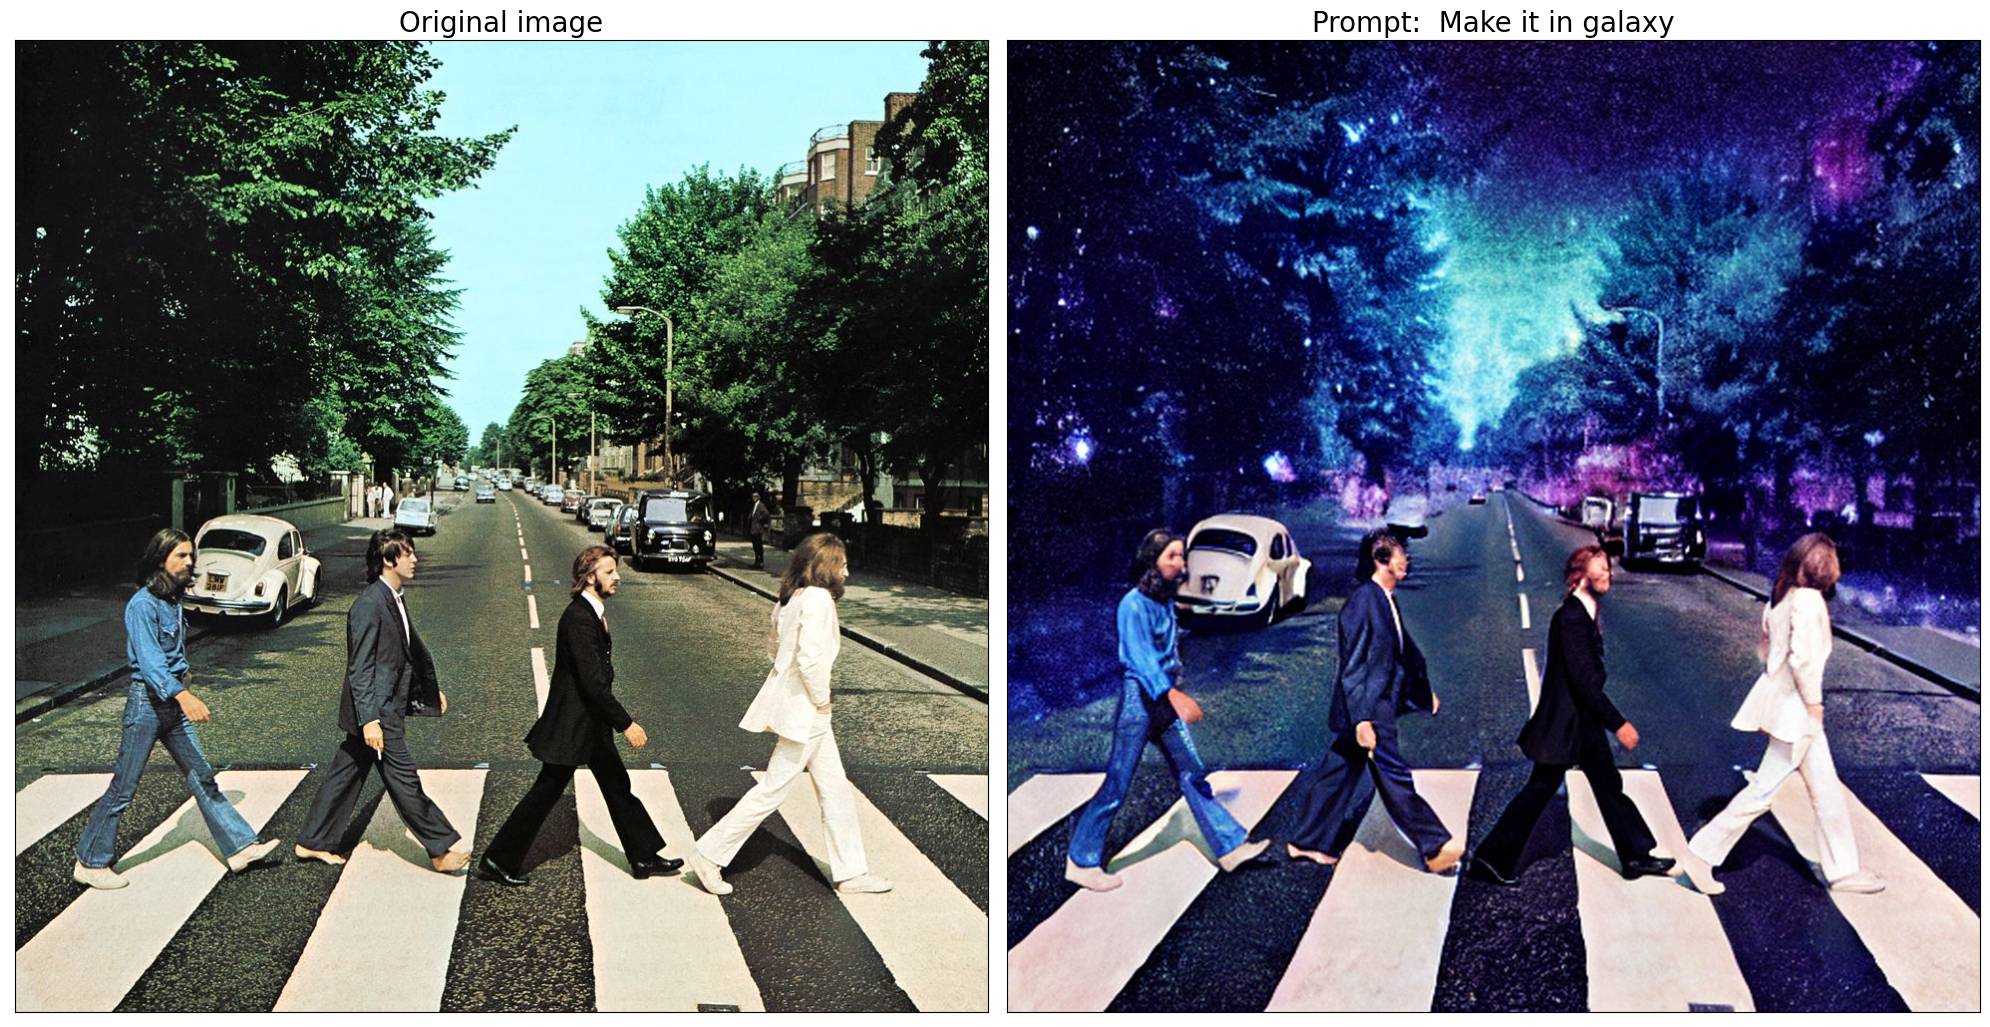

In [21]:
print('Pipeline settings')
print(f'Input text: {text_prompt.value}')
print(f'Seed: {seed.value}')
print(f'Number of steps: {num_steps.value}')
np.random.seed(seed.value)

int8_pipe = OVInstructPix2PixPipeline(tokenizer, scheduler, core, TEXT_ENCODER_OV_PATH, VAE_ENCODER_OV_PATH, UNET_INT8_OV_PATH, VAE_DECODER_OV_PATH, device=device.value)
processed_image = int8_pipe(text_prompt.value, image, num_steps.value)
fig = visualize_results(image, processed_image[0], text_prompt.value)

### Compare inference time of the converted IR and quantized models [$\Uparrow$](#Table-of-content:)

To measure the inference performance of the converted and quantized models, we use median inference time on calibration subset.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [18]:
%%skip not $to_quantize.value

import time

calibration_dataset = datasets.load_dataset("fusing/instructpix2pix-1000-samples", split="train", streaming=True)
validation_data = []
validation_size = 10
while len(validation_data) < validation_size:
    batch = next(iter(calibration_dataset))
    prompt = batch["edit_prompt"]
    input_image = batch["input_image"].convert("RGB")
    validation_data.append((prompt, input_image))

def calculate_inference_time(pix2pix_pipeline, calibration_dataset, size=10):
    inference_time = []
    for (prompt, image) in calibration_dataset:
        start = time.perf_counter()
        _ = pix2pix_pipeline(prompt, image)
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    return np.median(inference_time)

In [19]:
%%skip not $to_quantize.value

fp_pipe = OVInstructPix2PixPipeline(tokenizer, scheduler, core, TEXT_ENCODER_OV_PATH, VAE_ENCODER_OV_PATH, UNET_OV_PATH, VAE_DECODER_OV_PATH, device=device.value)
fp_pipe.set_progress_bar_config(disable=True)
fp_latency = calculate_inference_time(fp_pipe, validation_data)

int8_pipe.set_progress_bar_config(disable=True)
int8_latency = calculate_inference_time(int8_pipe, validation_data)
print(f"Performance speed up: {fp_latency / int8_latency:.3f}")

Performance speed up: 1.455


## Interactive demo with Gradio [$\Uparrow$](#Table-of-content:)

> **Note**: Diffusion process can take some time, depending on what hardware you select.

In [ ]:
import gradio as gr
from urllib.request import urlretrieve
from pathlib import Path
import numpy as np

default_url = "https://user-images.githubusercontent.com/29454499/223343459-4ac944f0-502e-4acf-9813-8e9f0abc8a16.jpg"
path = Path("data/example.jpg")
path.parent.mkdir(parents=True, exist_ok=True)
urlretrieve(default_url, path)


def generate(img, text, seed, num_steps, _=gr.Progress(track_tqdm=True)):
    if img is None:
        raise gr.Error("Please upload an image or choose one from the examples list")
    np.random.seed(seed)
    result = ov_pipe(text, img, num_steps)[0]
    return result


demo = gr.Interface(
    generate,
    [
        gr.Image(label="Image", type="pil"),
        gr.Textbox(label="Text"),
        gr.Slider(0, 1024, label="Seed", value=42),
        gr.Slider(
            1,
            100,
            label="Steps",
            value=10,
            info="Consider increasing the value to get more precise results. A suggested value is 100, but it will take more time to process.",
        ),
    ],
    gr.Image(label="Result"),
    examples=[[path, "Make it in galaxy"]],
)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/